# Advanced Deep Learning with Keras in Python

## Chapter 1. The Keras Functional API


### Input layers

In [1]:
# Import Input from keras.layers
from tensorflow.keras.layers import Input

# Create an input layer of shape 1
input_tensor = Input(shape=(1,))

### Dense layers

In [2]:
# Load layers
from tensorflow.keras.layers import Input, Dense

# Input layer
input_tensor = Input(shape=(1,))

# Dense layer
output_layer = Dense(1)

# Connect the dense layer to the input_tensor
output_tensor = output_layer(input_tensor)

This network will take the input, apply a linear coefficient to it, and return the result.

### Output layers

In [3]:
# Load layers
from tensorflow.keras.layers import Input, Dense

# Input layer
input_tensor = Input(shape=(1,))

# Create a dense layer and connect the dense layer to the input_tensor in one step
# Note that we did this in 2 steps in the previous exercise, but are doing it in one step now
output_tensor = Dense(1)(input_tensor)

The output layer allows your model to make predictions.

### Build a model

In [4]:
# Input/dense/output layers
from tensorflow.keras.layers import Input, Dense
input_tensor = Input(shape=(1,))
output_tensor = Dense(1)(input_tensor)

# Build the model
from tensorflow.keras.models import Model
model = Model(input_tensor, output_tensor)

### Compile a model

This finalizes your model, freezes all its settings, and prepares it to meet some data!

In [5]:
# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

### Visualize a model

Visualize model like under

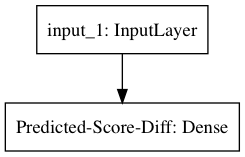

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


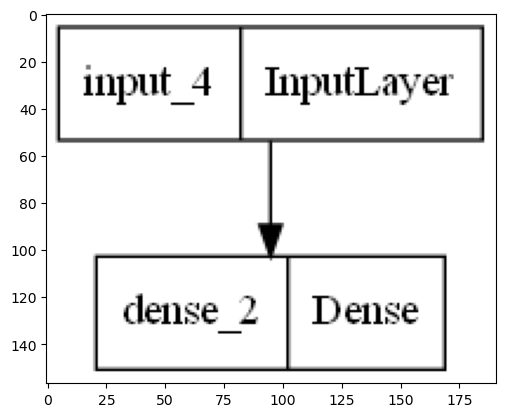

In [6]:
# Import the plotting function
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

# Summarize the model
model.summary()

# Plot the model
plot_model(model, to_file='model.png')

# Display the image
data = plt.imread('model.png')
plt.imshow(data)
plt.show()

#### Actual result in "Datacamp"

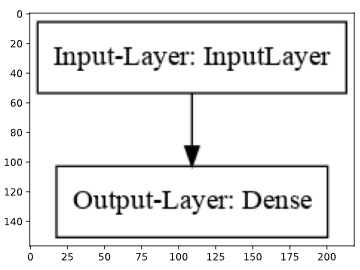

### Fit the model to the tournament basketball data

#### ============================= Run on Jupyter Only!! =============================

In [7]:
import pandas as pd

games_tourney = pd.read_csv('games_tourney.csv')
games_tourney_train = games_tourney.query('season < 2012')
games_tourney_test = games_tourney.query('season >= 2012')


#### =============================================================================

In [8]:
# Now fit the model
model.fit(games_tourney_train['seed_diff'], games_tourney_train['score_diff'],
          epochs=1,
          batch_size=128,
          validation_split=.10,
          verbose=True)

25/25 [==============================] - 0s 5ms/step - loss: 12.8872 - val_loss: 12.0797


### Evaluate the model on a test set

In [9]:
# Load the X variable from the test data
X_test = games_tourney_test['seed_diff']

# Load the y variable from the test data
y_test = games_tourney_test['score_diff']

# Evaluate the model on the test data
print(model.evaluate(X_test, y_test, verbose=False))

12.160466194152832


## Chapter 2. Two Input Networks Using Categorical Embeddings, Shared Layers, and Merge Layers

### Define team lookup

#### ============================= Run on Jupyter Only!! =============================

In [10]:
games_season = pd.read_csv('games_season.csv')

#### =============================================================================

In [11]:
# Imports
from tensorflow.keras.layers import Embedding
from numpy import unique

# Count the unique number of teams
n_teams = unique(games_season['team_1']).shape[0]

# Create an embedding layer
team_lookup = Embedding(input_dim=n_teams,
                        output_dim=1,
                        input_length=1,
                        name='Team-Strength')

The embedding layer is a lot like a dictionary, but your model learns the values for each key.

### Define team model

In [12]:
# Imports
from tensorflow.keras.layers import Input, Embedding, Flatten
from tensorflow.keras.models import Model

# Create an input layer for the team ID
teamid_in = Input(shape=(1,))

# Lookup the input in the team strength embedding layer
strength_lookup = team_lookup(teamid_in)

# Flatten the output
strength_lookup_flat = Flatten()(strength_lookup)

# Combine the operations into a single, re-usable model
team_strength_model = Model(teamid_in, strength_lookup_flat, name='Team-Strength-Model')

### Defining two inputs

In [13]:
# Load the input layer from tensorflow.keras.layers
from tensorflow.keras.layers import Input

# Input layer for team 1
team_in_1 = Input((1,), name='Team-1-In')

# Separate input layer for team 2
team_in_2 = Input((1,), name='Team-2-In')

These two inputs will be used later for the shared layer.

### Lookup both inputs in the same model

In [14]:
# Lookup team 1 in the team strength model
team_1_strength = team_strength_model(team_in_1)

# Lookup team 2 in the team strength model
team_2_strength = team_strength_model(team_in_2)

Now your model knows how strong each team is.

### Output layer using shared layer

In [15]:
# Import the Subtract layer from tensorflow.keras
from tensorflow.keras.layers import Subtract

# Create a subtract layer using the inputs from the previous exercise
score_diff = Subtract()([team_1_strength, team_2_strength])

This setup subracts the team strength ratings to determine a winner.

### Model using two inputs and one output

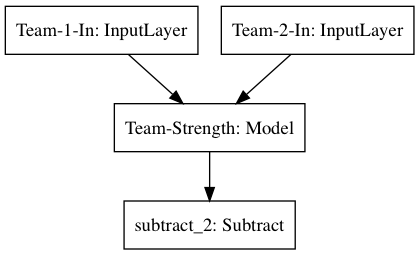

In [16]:
# Imports
from tensorflow.keras.layers import Subtract
from tensorflow.keras.models import Model

# Subtraction layer from previous exercise
score_diff = Subtract()([team_1_strength, team_2_strength])

# Create the model
model = Model([team_in_1, team_in_2], score_diff)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

### Fit the model to the regular season training data

In [17]:
# Get the team_1 column from the regular season data
input_1 = games_season['team_1']

# Get the team_2 column from the regular season data
input_2 = games_season['team_2']

# Fit the model to input 1 and 2, using score diff as a target
model.fit([input_1, input_2],
          games_season['score_diff'],
          epochs=1,
          batch_size=2048,
          validation_split=.1,
          verbose=True)

138/138 [==============================] - 0s 1ms/step - loss: 12.1203 - val_loss: 11.8384


Now our model has learned a strength rating for every team.

### Evaluate the model on the tournament test data

In [18]:
# Get team_1 from the tournament data
input_1 = games_tourney['team_1']

# Get team_2 from the tournament data
input_2 = games_tourney['team_2']

# Evaluate the model using these inputs
print(model.evaluate([input_1, input_2], games_tourney['score_diff'], verbose=False))

11.682303428649902


## Chapter 3. Multiple Inputs: 3 Inputs (and Beyond!)

### Make an input layer for home vs. away

You know there is a well-documented home-team advantage in basketball, so you will add a new input to your model to capture this effect.



#### ============================= Run on Jupyter Only!! =============================

In [19]:
from tensorflow.keras.layers import Concatenate

#### =============================================================================

In [20]:
# Create an Input for each team
team_in_1 = Input(shape=(1,), name='Team-1-In')
team_in_2 = Input(shape=(1,), name='Team-2-In')

# Create an input for home vs away
home_in = Input(shape=(1,), name='Home-In')

# Lookup the team inputs in the team strength model
team_1_strength = team_strength_model(team_in_1)
team_2_strength = team_strength_model(team_in_2)

# Combine the team strengths with the home input using a Concatenate layer, then add a Dense layer
out = Concatenate()([team_1_strength, team_2_strength, home_in])
out = Dense(1)(out)

Now you have a model with 3 inputs!

### Make a model and compile it

In [21]:
# Import the model class
from tensorflow.keras.models import Model

# Make a Model
model = Model([team_in_1, team_in_2, home_in], out)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

### Fit the model and evaluate

In [22]:
# Fit the model to the games_season dataset
model.fit([games_season['team_1'], games_season['team_2'], games_season['home']],
          games_season['score_diff'],
          epochs=1,
          verbose=True,
          validation_split=.1,
          batch_size=2048)

# Evaluate the model on the games_tourney dataset
print(model.evaluate([games_tourney['team_1'], games_tourney['team_2'], games_tourney['home']], games_tourney['score_diff'], verbose=False))

138/138 [==============================] - 0s 2ms/step - loss: 12.0768 - val_loss: 12.2364
11.689693450927734


### Model summaries

In [23]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Team-1-In (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 Team-2-In (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 Team-Strength-Model (Functiona  (None, 1)           10888       ['Team-1-In[0][0]',              
 l)                                                               'Team-2-In[0][0]']              
                                                                                                  
 Home-In (InputLayer)           [(None, 1)]          0           []                         

#### Q. How many total parameters does this model have?
=> 10,892

#### Q. How many trainable parameters does this model have?
=> 10,892

#### Q. Which layer of your model has the most trainable parameters?
=> Team-Strength (Model)

### Plotting models

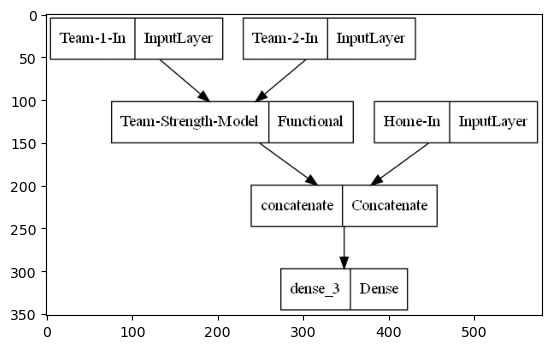

In [24]:
# Imports
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

# Plot the model
plot_model(model, to_file='model.png')

# Display the image
data = plt.imread('model.png')
plt.imshow(data)
plt.show()

#### Q. How many inputs does this model have?
=> 3

#### Q. How many outputs does this model have?
=> 1

#### Q. Which layer is shared between 2 inputs?
=> Team-Strength

### Add the model predictions to the tournament data

In [25]:
# Predict
games_tourney['pred'] = model.predict([games_tourney['team_1'],games_tourney['team_2'],games_tourney['home']])

133/133 [==============================] - 0s 522us/step


Now you can try building a model for the tournament data based on your regular season predictions

### Create an input layer with multiple columns

In [26]:
# Create an input layer with 3 columns
input_tensor = Input((3,))

# Pass it to a Dense layer with 1 unit
output_tensor = Dense(1)(input_tensor)

# Create a model
model = Model(input_tensor, output_tensor)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

### Fit the model

#### ============================= Run on Jupyter Only!! =============================

In [27]:
games_tourney_train = games_tourney.query('season < 2012')
games_tourney_test = games_tourney.query('season >= 2012')

#### =============================================================================

In [28]:
# Fit the model
model.fit(games_tourney_train[['home', 'seed_diff', 'pred']],
          games_tourney_train['score_diff'],
          epochs=1,
          verbose=True)

108/108 [==============================] - 0s 553us/step - loss: 13.4544


### Evaluate the model

#### ============================= Run on Jupyter Only!! =============================

In [29]:
# Evaluate the model on the games_tourney_test dataset
print(model.evaluate(games_tourney_test[['home', 'seed_diff', 'pred']], games_tourney_test['score_diff'], verbose=False))

12.569252967834473


#### ※ CHANGE PARAMETER 'pred' to 'prediction' when running on DATACAMP!!

#### =============================================================================

## Chapter 4. Multiple Outputs

### Simple two-output model

"Multiple target regression": one model making more than one prediction.

In [30]:
# Define the input
input_tensor = Input((2,))

# Define the output
output_tensor = Dense(2)(input_tensor)

# Create a model
model = Model(input_tensor, output_tensor)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

### Fit a model with two outputs

 This model will predict the scores of both teams.

In [31]:
# Fit the model
model.fit(games_tourney_train[['seed_diff', 'pred']],
  		  games_tourney_train[['score_1', 'score_2']],
  		  verbose=True,
  		  epochs=100,
  		  batch_size=16384)

Epoch 1/100
1/1 [==============================] - 0s 170ms/step - loss: 71.6407
Epoch 2/100
1/1 [==============================] - 0s 3ms/step - loss: 71.6395
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 71.6383
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 71.6371
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 71.6359
Epoch 6/100
1/1 [==============================] - 0s 998us/step - loss: 71.6348
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 71.6336
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 71.6324
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 71.6312
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 71.6300
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 71.6288
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 71.6276
Epoch 13/100
1/1 [===========================

### Inspect the model (I)

The input layer will have 4 weights: 2 for each input times 2 for each output.

The output layer will have 2 weights, one for each output.

In [32]:
# Print the model's weights
print(model.get_weights())

# Print the column means of the training data
print(games_tourney_train.mean())

[array([[-0.5616421 , -0.86409044],
       [-0.19787957,  0.19206382]], dtype=float32), array([0.09999995, 0.09999995], dtype=float32)]
season        1998.074052
team_1        5556.771429
team_2        5556.771429
home             0.000000
seed_diff        0.000000
score_diff       0.000000
score_1         71.621283
score_2         71.621283
won              0.500000
pred             0.188671
dtype: float64


### Evaluate the model

In [33]:
# Evaluate the model on the tournament test data
model.evaluate(games_tourney_test[['seed_diff', 'pred']],games_tourney_test[['score_1', 'score_2']])

26/26 [==============================] - 0s 519us/step - loss: 68.9418


68.9417953491211

### Classification and regression in one model

In [34]:
# Create an input layer with 2 columns
input_tensor = Input((2,))

# Create the first output
output_tensor_1 = Dense(1, activation='linear', use_bias=False)(input_tensor)

# Create the second output (use the first output as input here)
output_tensor_2 = Dense(1, activation='sigmoid', use_bias=False)(output_tensor_1)

# Create a model with 2 outputs
model = Model(input_tensor, [output_tensor_1, output_tensor_2])

### Compile and fit the model

In [35]:
# Import the Adam optimizer
from tensorflow.keras.optimizers import Adam

# Compile the model with 2 losses and the Adam optimzer with a higher learning rate
model.compile(loss=['mean_absolute_error', 'binary_crossentropy'], optimizer=Adam(learning_rate=0.01))

# Fit the model to the tournament training data, with 2 inputs and 2 outputs
model.fit(games_tourney_train[['seed_diff', 'pred']],
          [games_tourney_train[['score_diff']], games_tourney_train[['won']]],
          epochs=10,
          verbose=True,
          batch_size=16384)

Epoch 1/10
1/1 [==============================] - 0s 312ms/step - loss: 18.9426 - dense_6_loss: 16.9320 - dense_7_loss: 2.0105
Epoch 2/10
1/1 [==============================] - 0s 2ms/step - loss: 18.8612 - dense_6_loss: 16.8807 - dense_7_loss: 1.9805
Epoch 3/10
1/1 [==============================] - 0s 2ms/step - loss: 18.7801 - dense_6_loss: 16.8294 - dense_7_loss: 1.9507
Epoch 4/10
1/1 [==============================] - 0s 2ms/step - loss: 18.6994 - dense_6_loss: 16.7781 - dense_7_loss: 1.9212
Epoch 5/10
1/1 [==============================] - 0s 2ms/step - loss: 18.6189 - dense_6_loss: 16.7269 - dense_7_loss: 1.8920
Epoch 6/10
1/1 [==============================] - 0s 2ms/step - loss: 18.5387 - dense_6_loss: 16.6757 - dense_7_loss: 1.8630
Epoch 7/10
1/1 [==============================] - 0s 2ms/step - loss: 18.4588 - dense_6_loss: 16.6245 - dense_7_loss: 1.8343
Epoch 8/10
1/1 [==============================] - 0s 2ms/step - loss: 18.3792 - dense_6_loss: 16.5733 - dense_7_loss: 1.805

### Inspect the model (II)

In [36]:
# Print the model weights
print(model.get_weights())

# Print the training data means
print(games_tourney_train.mean())

[array([[-1.0198863 ],
       [ 0.43905425]], dtype=float32), array([[-1.36336]], dtype=float32)]
season        1998.074052
team_1        5556.771429
team_2        5556.771429
home             0.000000
seed_diff        0.000000
score_diff       0.000000
score_1         71.621283
score_2         71.621283
won              0.500000
pred             0.188671
dtype: float64


In [37]:
# Import the sigmoid function from scipy
from scipy.special import expit as sigmoid

# Weight from the model
weight = 0.14

# Print the approximate win probability predicted close game
print(sigmoid(1 * weight))

# Print the approximate win probability predicted blowout game
print(sigmoid(10 * weight))

0.5349429451582145
0.8021838885585818


So `sigmoid(1 * 0.14)` is `0.53`, which represents a pretty close game and `sigmoid(10 * 0.14)` is `0.80`, which represents a pretty likely win.

In other words, if the model predicts a win of 1 point, it is less sure of the win than if it predicts 10 points. Who says neural networks are black boxes?

### Evaluate on new data with two metrics

Keras will return 3 numbers: 

The first number will be the sum of both the loss functions, 

The next 2 numbers will be the loss functions you used when defining the model.

In [38]:
# Evaluate the model on new data
print(model.evaluate(games_tourney_test[['seed_diff', 'pred']],
               [games_tourney_test[['score_diff']], games_tourney_test[['won']]], verbose=False))

[17.525175094604492, 15.603510856628418, 1.921664834022522]


Model plays a role as a regressor and a good classifier